In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import scvelo as scv
import scanpy as sc
import pandas as pd
import collections
import numpy as np
import matplotlib
import fsspec
import scvi
import h5py
import anndata
import network
import networkx
import desc 
import os
import umap
import h5py
import igraph
%load_ext rpy2.ipython
%matplotlib inline 
sc.settings.verbosity = 3     
np.random.seed(42)
sc.set_figure_params(figsize=(4, 4))

Global seed set to 0
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


... reading from cache file cache/Users-brendamelano-Desktop-10xver7-OS384-OS384.h5ad


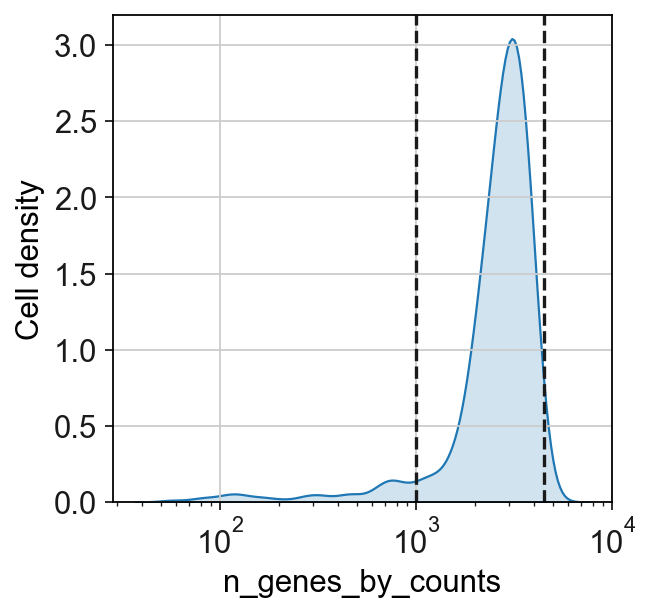

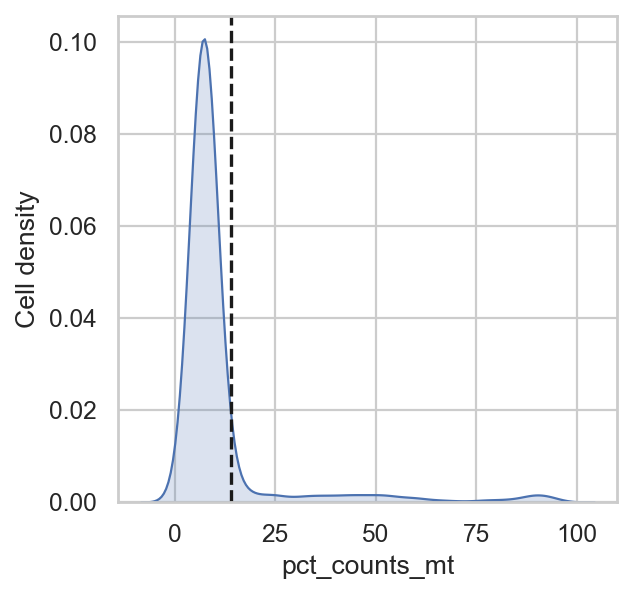

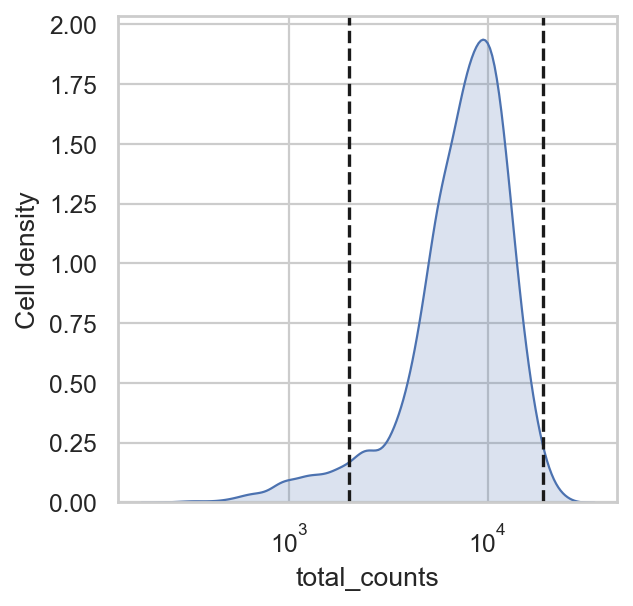

Filtered out 53345 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 1500 highly variable genes.
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
`n_top_genes` > `adata.n_var`, returning all genes.
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
97
62
calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    416 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    531 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)
regressing out ['n_counts', 'pct_counts_mt', 'ccdifference']
    sparse input is densified and may lead to high memory use
    finished (

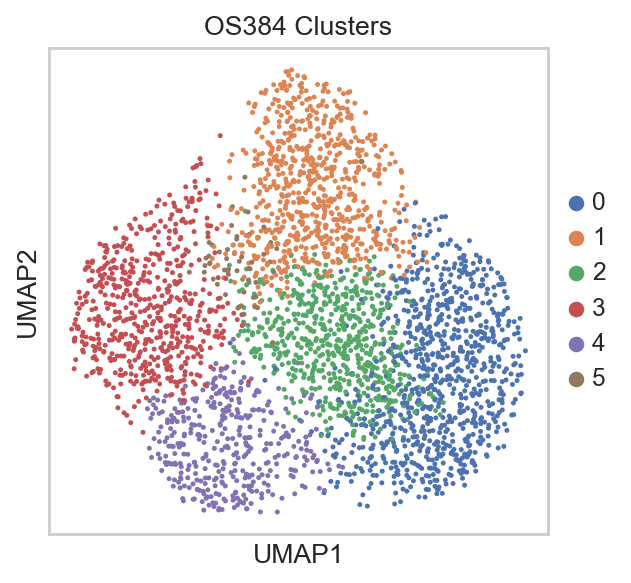

In [2]:
# Reading in OS384 loom file
adata = scv.read('/Users/brendamelano/Desktop/10xver7/OS384/OS384.loom', cache = True)


# Ensuring that all variable names are unique
adata.var_names_make_unique()


# Making the var names unique
adata.var_names_make_unique()

# Filtering as is done in Seurat
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'

# Computing mitochondrial percentage
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)


## Filtering based on number of genes that have at least 1 count
plt.figure()
sns.kdeplot(data=adata.obs, x='n_genes_by_counts', fill=True, alpha=0.2, log_scale=True)

# Add a vertical line at x = 20000
plt.axvline(x=4500, color='k', linestyle='--')
plt.axvline(x=1000, color='k', linestyle='--')


# Set labels and a classic theme
plt.xlabel("n_genes_by_counts")
plt.ylabel("Cell density")
sns.set_theme(style="whitegrid")  # This sets a theme somewhat similar to theme_classic()

plt.show()



## Percent mitochondrial reads

#This may only show up correctly after filtering
plt.figure()
sns.kdeplot(data=adata.obs, x='pct_counts_mt', fill=True, alpha=0.2)

# Add a vertical line at x = 20000
plt.axvline(x=14, color='k', linestyle='--')

# Set labels and a classic theme
plt.xlabel("pct_counts_mt")
plt.ylabel("Cell density")
sns.set_theme(style="whitegrid")  # This sets a theme somewhat similar to theme_classic()

plt.show()



## Filtering based on total counts

plt.figure()
sns.kdeplot(data=adata.obs, x='total_counts', fill=True, alpha=0.2, log_scale=True)

# Add a vertical line at x = 20000
plt.axvline(x=2000, color='k', linestyle='--')
plt.axvline(x=19000, color='k', linestyle='--')

# Set labels and a classic theme
plt.xlabel("total_counts")
plt.ylabel("Cell density")
sns.set_theme(style="whitegrid")  # This sets a theme somewhat similar to theme_classic()

plt.show()


# Filtering the dataset
# Filtering the adata set based on total counts, genes and mitochondrial percentage
adata = adata[(adata.obs['total_counts'] >= 2000) &
                        (adata.obs['total_counts'] <= 19000) &
                        (adata.obs['n_genes_by_counts'] >= 1000) &
                        (adata.obs['n_genes_by_counts'] < 4500) & #pct_counts_mt
                        (adata.obs['pct_counts_mt'] < 14)
                        ]

# weren't the samples filtered in seurat? check which additional cells and genes are filtered out here
scv.pp.filter_genes(adata, min_shared_counts=20)


# normalizing the cells by all counts across all the genes
scv.pp.normalize_per_cell(adata)


# filtering the dataset to only keep the most variable genes
# this is redundant to selecting highly variable genes
scv.pp.filter_genes_dispersion(adata, n_top_genes=1500)


# Log scaling
scv.pp.log1p(adata)


# preserving the counts
adata.layers["counts"] = adata.X.copy() 



# freezing the data in raw
adata.raw = adata


# creating a df with the indexes (CellIDs from the adata object)
sample_one_index = pd.DataFrame(adata.obs.index)


# Selecting highly variable genes
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=3000, 
    subset=True,
    layer="counts"
)

genes = adata.var.index.values

cell_cycle_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/scvi/regev_lab_cell_cycle_genes.txt')]
print(len(cell_cycle_genes))

# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
print(len(cell_cycle_genes))


sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

adata.obs['ccdifference'] = adata.obs['S_score'] - adata.obs['G2M_score']

# Linear dimensionality reduction
#sc.pp.normalize_total(adata, target_sum=1e4)
#sc.pp.log1p(adata)
#sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
#adata.raw = adata
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['n_counts', 'pct_counts_mt', 'ccdifference'])
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')


sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20)

sc.tl.umap(adata)

sc.tl.leiden(adata, resolution = 0.7)

# making the var names unique
adata.var_names_make_unique()

genes = adata.var.index.values



# Plotting the umap based on leiden clusters
sc.pl.umap(
    adata,
    color=["leiden"],
    frameon= True,
    title = "OS384 Clusters",
    size = 20
)

# Marker identification with PCA dim reduction

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


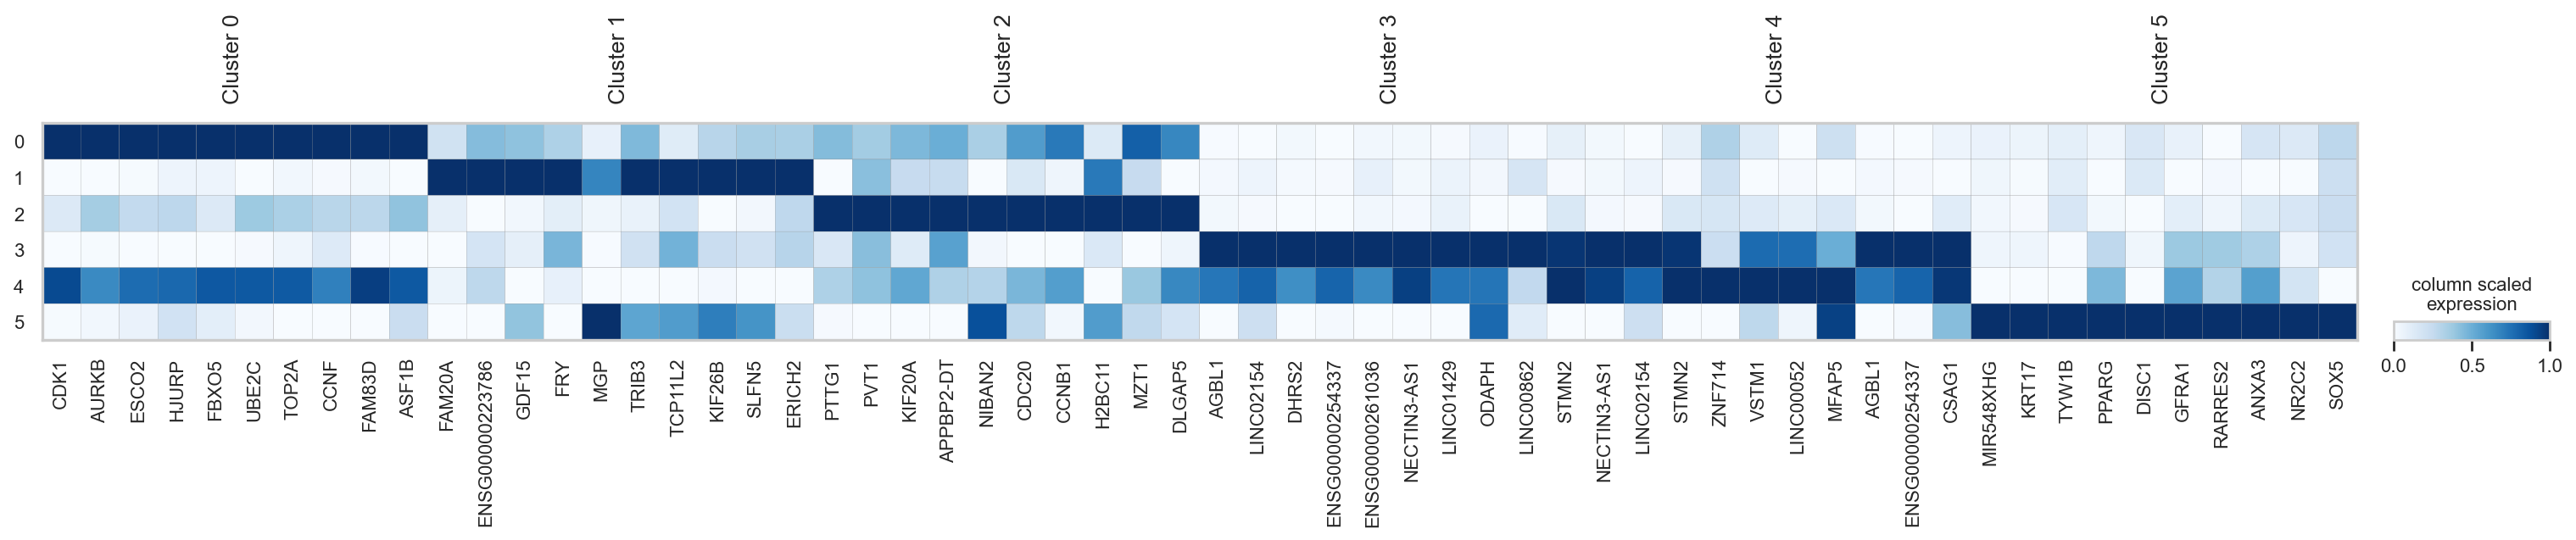

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


,0,1,2,3,4,5
0,UBE2C,COL1A1,PTTG1,RPS4X,LINC02154,RBP1
1,AURKB,COL1A2,HSP90AB1,LINC02154,RPS4X,NCL
2,CDK1,COL6A3,JPT1,AGBL1,COL8A1,ANXA3
3,TOP2A,PHGDH,VIM,COL8A1,CSAG1,CDA
4,TUBB,ITGA11,UBE2S,CSAG1,GMNN,KRT18
5,HMGB2,ARL4C,MT2A,STMN2,FABP4,MYL9
6,UBE2T,HTRA1,CDKN3,KRT8,STMN2,LUM
7,DIAPH3,HLA-A,H2AZ1,FTH1,HMGB2,EPRS1
8,KPNA2,NEAT1,HSPD1,HAPLN1,TNNT1,PALLD
9,CENPK,SQSTM1,HSP90AA1,FTL,UBE2T,CNN1


In [3]:
# Perform Differential Gene Expression Analysis
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')


# Extract gene names and log fold changes into a DataFrame
gene_names_df = pd.DataFrame(adata.uns['rank_genes_groups']['names'])
logfc_df = pd.DataFrame(adata.uns['rank_genes_groups']['logfoldchanges'])


# Filter for logFC > 1. This involves checking each gene's logFC across all clusters
# and selecting the gene if it has logFC > 1 in any of the clusters.
filtered_genes = gene_names_df[logfc_df > 1].stack().reset_index(level=1, drop=True).unique()

top_genes_by_cluster = {}  # Dictionary to hold top genes for each cluster

# Assuming gene_names_df and logfc_df have been correctly defined as before
num_clusters = gene_names_df.shape[1]

for cluster_idx in range(num_clusters):
    sorted_genes = logfc_df.iloc[:, cluster_idx].sort_values(ascending=False).head(10).index
    top_genes = gene_names_df.iloc[sorted_genes, cluster_idx].values
    top_genes_by_cluster[f"Cluster {cluster_idx}"] = top_genes
    
sc.pl.matrixplot(
    adata,
    top_genes_by_cluster,
    "leiden",
    #dendrogram=True,
    cmap="Blues",
    standard_scale="var",
    colorbar_title="column scaled\nexpression",
)

# Performing DGEA between clusters
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')


cluster_markers = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(60)


cluster_markers

# scVI

In [ ]:

# removing the suffix and prefix from the index column within the adata object
adata.obs.index = adata.obs.index.map(lambda x: x.lstrip('OS384:').rstrip('x'))


# reading in the cell IDs
sample_obs = pd.read_csv("/Users/brendamelano/Desktop/os_data/OS384/cellID_obs_384.csv")


# removing the suffix from the seurat barcodes
sample_obs["x"] = sample_obs["x"].map(lambda x: x.lstrip('').rstrip('-1'))


# filtering the adata object based on the seurat sample observations
adata = adata[np.isin(adata.obs.index,sample_obs["x"])]


# reading in the ccdifference scores
ccdifference = pd.read_csv("/Users/brendamelano/Desktop/os_data/OS384/CCdifference.csv")


# reading in the percent.mt scores
percent_mt = pd.read_csv("/Users/brendamelano/Desktop/os_data/OS384/percent.mt.csv")


# filtering genes
sc.pp.filter_genes(adata, min_counts=3)
sc.pp.filter_cells(adata, min_counts=3)


# normalizing the counts
adata.layers["counts"] = adata.X.copy() # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)


# log normalizing the data
sc.pp.log1p(adata)
#adata.raw = adata # freeze the state in `.raw`


# feature selection
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=3500, # try 3k or 4k
    subset=True,
    layer="counts",
    flavor="seurat_v3"
)


# creating a df with the indexes (CellIDs from the adata object)
sample_one_index = pd.DataFrame(adata.obs.index)


# concatenating the umap embeddings and the cluster identity
objs = [sample_obs, ccdifference]


# concatenating the ccdifference and sample observations
ccdif = pd.concat(objs, axis = 1, ignore_index = True)


# dropping the 3rd column from the umap clusters df
ccdif = ccdif.drop(columns = 1)


# renaming the Cell ID column
ccdif = ccdif.rename(columns = {0:'CellID'})


# renaming the Cell ID column
ccdif = ccdif.rename(columns = {2:'ccdifference'})

# concatenating the umap embeddings and the cluster identity
objs = [ccdif, percent_mt]
ccdif = pd.concat(objs, axis = 1, ignore_index = True)


# dropping the 3rd column from the umap clusters df
ccdif = ccdif.drop(columns = 2)


# renaming the Cell ID column
ccdif = ccdif.rename(columns = {0:'CellID'})


# renaming the Cell ID column
ccdif = ccdif.rename(columns = {1:'ccdifference'})

# renaming the Cell ID column
ccdif = ccdif.rename(columns = {3:'percent.mt'})

# ordering the umap object based on the sample index
ccdif_ordered = sample_one_index.merge(ccdif, on = "CellID")


# filtering the adata object based on the seurat sample observations
adata = adata[np.isin(adata.obs.index,ccdif["CellID"])]


# filtering the adata object based on the seurat sample observations
ccdif_ordered = ccdif_ordered[np.isin(ccdif_ordered["CellID"], adata.obs.index)]


# filtering the adata object based on the seurat sample observations
adata = adata[np.isin(adata.obs.index,ccdif_ordered["CellID"])]


# setting the index to CellID 
ccdif_ordered = ccdif_ordered.set_index('CellID')



ccdif_values = ccdif_ordered['ccdifference']



adata.obs['ccdifference'] = ccdif_values.values

# assigning the cluster ids to the adata object
adata.obs['ccdifference'] = ccdif_ordered['ccdifference']

# adding percent mt reads to the adata object
adata.obs['percent.mt'] = ccdif_ordered['percent.mt']

# setting up the anndata object to include categorical and continuous covariate variables
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    continuous_covariate_keys=["percent.mt", "ccdifference"]
)

# creating a model for my adata object
model = scvi.model.SCVI(adata)

# inspecting the structure of the model
model

# training the model
model.train()

# reading in the adata file from the data integration script
adata = scvi.read("/Users/brendamelano/Desktop/os_data/OS384/scvi_384_adata.h5ad")

# saving my model
model.save("OS384_scvi_model/")

# loading the model
#model = scvi.model.SCVI.load("OS384_scvi_model/", adata, use_gpu=False)

# saving the normalized expression in a different layer 
adata.layers["scvi_normalized"] = model.get_normalized_expression(
    library_size=10e4
)

# getting the latent representation
latent = model.get_latent_representation()

# adding the latent variables to the adata object
adata.obsm["X_scVI"] = latent

# using the latent space for umap generation
sc.pp.neighbors(adata, use_rep="X_scVI")


# computing umap
sc.tl.umap(adata, min_dist=0.3)


# clustering using the leiden algorithm
# neighbors were already computed using scVI
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=1)



# Set the plot style to 'white' to remove grid lines
sns.set_style('white')

# clustering using the leiden algorithm
# neighbors were already computed using scVI
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=0.5)


# plotting the clusters
sc.pl.umap(
    adata,
    color=["leiden_scVI"],
    frameon=True,
    title = 'OS384 clusters'#,
    #save = "OS384_LT_umap.svg"
)

# creating a dataframe with the cluster IDs
clusters = pd.DataFrame(adata.obs['leiden_scVI'].astype('int64').values)

# Define the number of clusters
n_clusters = len(clusters[0].unique())

# Define a color palette with a limited number of colors
colors = sns.color_palette('pastel', n_clusters)

# Create a dictionary that maps each cluster ID to a color from the palette
cluster_colors = dict(zip(sorted(clusters[0].unique()), colors))

# Map the cluster IDs to their corresponding colors
adata.uns['ClusterName_colors'] = [cluster_colors[c] for c in clusters[0]]

# saving the adata file with the cluster ids
adata.write("/Users/brendamelano/Desktop/os_data/OS384/scvi_384_adata.h5ad")

# Identifying Subtype A markers

In [5]:
# Assuming you want to extract data for the first cluster (index '0')
cluster_id = '1'  # Adjust based on your cluster of interest

genes = pd.DataFrame(adata.uns['rank_genes_groups']['names'][cluster_id]).head(60)
p_values = pd.DataFrame(adata.uns['rank_genes_groups']['pvals'][cluster_id]).head(60)
adjusted_p_values = pd.DataFrame(adata.uns['rank_genes_groups']['pvals_adj'][cluster_id]).head(60)
log_fold_changes = pd.DataFrame(adata.uns['rank_genes_groups']['logfoldchanges'][cluster_id]).head(60)
scores = pd.DataFrame(adata.uns['rank_genes_groups']['scores'][cluster_id]).head(60)

# Combine into a single DataFrame
cluster_markers = pd.DataFrame({
    'genes': genes.values.flatten(),  # Ensure it's a 1D array
    'p_values': p_values.values.flatten(),
    'adjusted_p_values': adjusted_p_values.values.flatten(),
    'log_fold_changes': log_fold_changes.values.flatten(),
    'scores': scores.values.flatten()
})


# Sort the DataFrame by log_fold_changes in descending order
OS384_subtype_A_markers = cluster_markers.sort_values(by='log_fold_changes', ascending=False)

OS384_subtype_A_markers

Subtype_A_genes_384 = cluster_markers.iloc[:, 1].tolist()

,genes,p_values,adjusted_p_values,log_fold_changes,scores
31,GDF15,5.007188e-27,6.954427e-26,2.060725,10.765532
11,TRIB3,2.139639e-44,7.132131e-43,1.700290,13.977468
42,SLFN5,1.444851e-21,1.454863e-20,1.693909,9.538807
6,HTRA1,5.702625e-55,3.421575e-53,1.534259,15.615578
15,UNC5B,1.878236e-38,4.695589e-37,1.503851,12.967176
2,COL6A3,2.168025e-78,3.613375e-76,1.352557,18.743977
44,SESN2,1.742936e-20,1.686712e-19,1.203786,9.277015
0,COL1A1,5.505065e-166,8.257598e-163,1.200896,27.458466
47,ARMC9,6.765071e-19,6.225526e-18,1.200444,8.878693
20,GAS5,5.817205e-36,1.195316e-34,1.186703,12.519813


In [11]:
# Write the array to a CSV file
np.savetxt("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS384_subtype_A_markers.csv", Subtype_A_genes_384, delimiter=",", fmt='%s')


computing score 'angiogenic_score'
    finished: added
    'angiogenic_score', score of gene set (adata.obs).
    109 total control genes are used. (0:00:00)


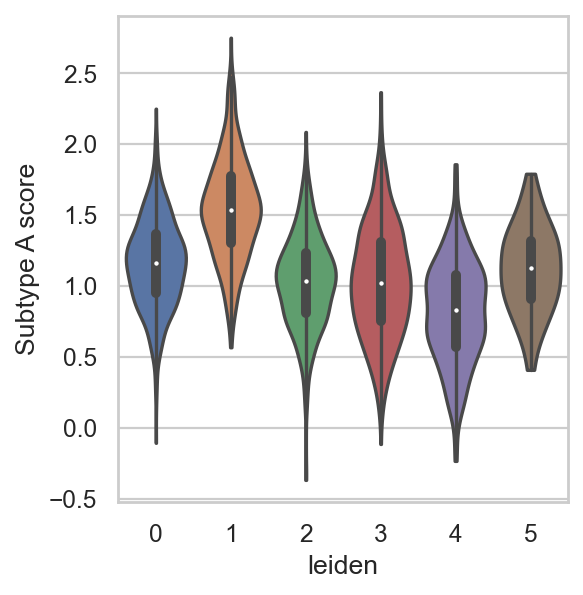

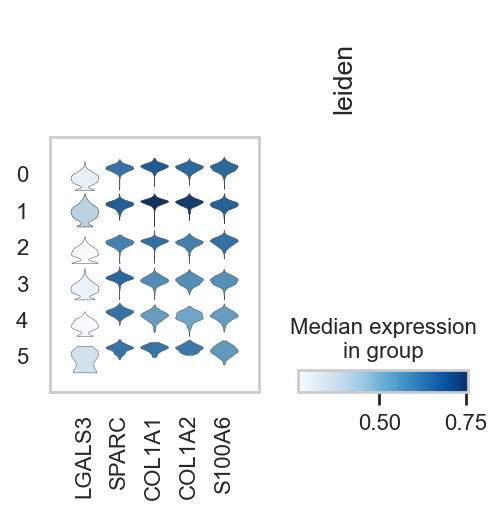

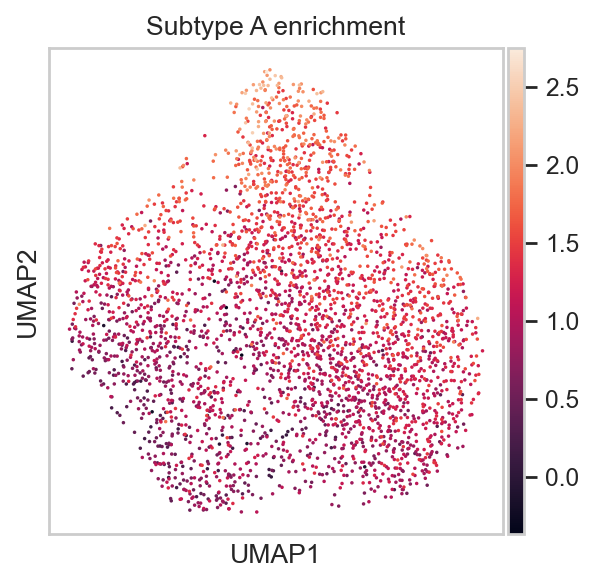

In [28]:
# reading in gene lists for gsea
angiogenic_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/gmt_files/Subtype_A_module.csv')]


adata.var_names_make_unique()


# keeping only genes that appear in the adata
angiogenic_genes = [x for x in angiogenic_genes if x in adata.var_names]


# Computing gsea
sc.tl.score_genes(adata, angiogenic_genes, ctrl_size=50, gene_pool=None, n_bins=25, 
                  score_name='angiogenic_score', random_state=0, copy=False, use_raw=None)

sc.pl.violin(adata, ['angiogenic_score'], groupby='leiden', stripplot=False, inner='box', 
             ylabel = 'Subtype A score')


sc.pl.stacked_violin(adata, angiogenic_genes, groupby='leiden',
                         var_group_positions=[(7, 8)], var_group_labels=['leiden'],
                    standard_scale="var",)

sc.pl.umap(
    adata,
    color=["angiogenic_score"],
   # frameon=False,
    title = 'Subtype A enrichment',
    size = 10,
    legend_fontsize = 7
)

# Subtype B marker identification

In [8]:
# Assuming you want to extract data for the first cluster (index '0')
cluster_id = '0'  # Adjust based on your cluster of interest

genes = pd.DataFrame(adata.uns['rank_genes_groups']['names'][cluster_id]).head(60)
p_values = pd.DataFrame(adata.uns['rank_genes_groups']['pvals'][cluster_id]).head(60)
adjusted_p_values = pd.DataFrame(adata.uns['rank_genes_groups']['pvals_adj'][cluster_id]).head(60)
log_fold_changes = pd.DataFrame(adata.uns['rank_genes_groups']['logfoldchanges'][cluster_id]).head(60)
scores = pd.DataFrame(adata.uns['rank_genes_groups']['scores'][cluster_id]).head(60)

# Combine into a single DataFrame
cluster_markers = pd.DataFrame({
    'genes': genes.values.flatten(),  # Ensure it's a 1D array
    'p_values': p_values.values.flatten(),
    'adjusted_p_values': adjusted_p_values.values.flatten(),
    'log_fold_changes': log_fold_changes.values.flatten(),
    'scores': scores.values.flatten()
})


# Sort the DataFrame by log_fold_changes in descending order
OS384_subtype_B_markers = cluster_markers.sort_values(by='log_fold_changes', ascending=False)

OS384_subtype_B_markers

OS384_subtype_B_markers = OS384_subtype_B_markers.iloc[:, 0].tolist()

OS384_subtype_B_markers

#np.savetxt("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS384_subtype_B_markers.csv", OS384_subtype_B_markers, delimiter=",", fmt='%s')


,genes,p_values,adjusted_p_values,log_fold_changes,scores
2,CDK1,3.130214e-135,1.565107e-132,2.528506,24.749613
1,AURKB,1.324512e-137,9.933837e-135,2.374106,24.969105
18,HJURP,2.617752e-65,1.963314e-63,2.199638,17.066891
13,FBXO5,2.922923e-72,3.131703e-70,2.129969,17.977516
0,UBE2C,2.161089e-138,3.241634e-135,2.117594,25.041494
3,TOP2A,4.470170e-121,1.676314e-118,2.046645,23.398081
42,FAM83D,9.743836e-46,3.247945e-44,1.889596,14.195679
56,ASF1B,9.376400e-40,2.383831e-38,1.764749,13.194993
11,NDC80,5.602714e-77,7.003392e-75,1.726455,18.570168
31,CKAP2L,1.048086e-52,4.764027e-51,1.689574,15.279458


computing score 'Subtype_B_score'
    finished: added
    'Subtype_B_score', score of gene set (adata.obs).
    386 total control genes are used. (0:00:00)


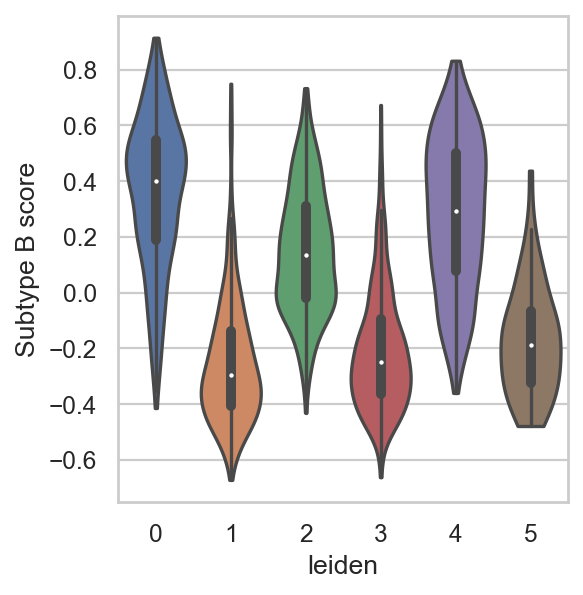

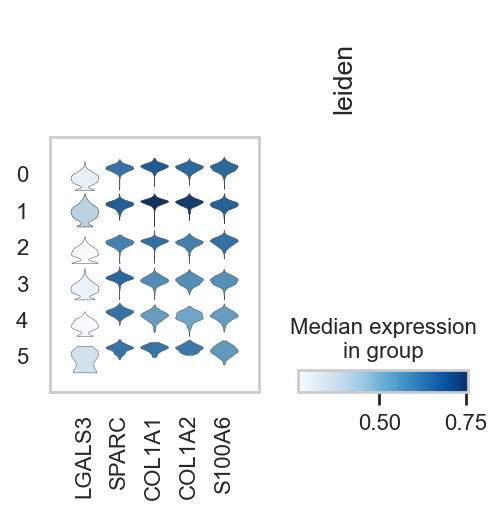

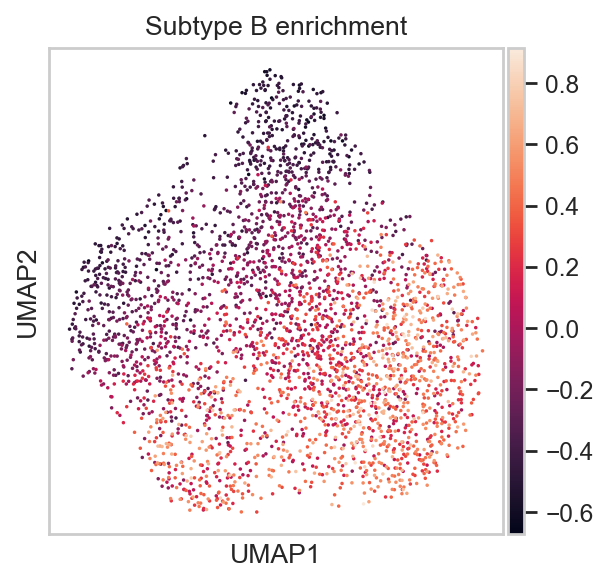

In [29]:
# Computing subtype B score
# reading in gene lists for gsea
subtype_B_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/gmt_files/Subtype_B_module.csv')]


adata.var_names_make_unique()


# keeping only genes that appear in the adata
subtype_B_genes = [x for x in subtype_B_genes if x in adata.var_names]


# Computing gsea
sc.tl.score_genes(adata, subtype_B_genes, ctrl_size=50, gene_pool=None, n_bins=25, 
                  score_name='Subtype_B_score', random_state=0, copy=False, use_raw=None)

sc.pl.violin(adata, ['Subtype_B_score'], groupby='leiden', stripplot=False, inner='box', 
             ylabel = 'Subtype B score')


sc.pl.stacked_violin(adata, angiogenic_genes, groupby='leiden',
                         var_group_positions=[(7, 8)], var_group_labels=['leiden'],
                    standard_scale="var",)

sc.pl.umap(
    adata,
    color=["Subtype_B_score"],
   # frameon=False,
    title = 'Subtype B enrichment',
    size = 10,
    legend_fontsize = 7
)

# Subtype C Marker identification

In [8]:
# Assuming you want to extract data for the first cluster (index '0')
cluster_id = '3'  # Adjust based on your cluster of interest

genes = pd.DataFrame(adata.uns['rank_genes_groups']['names'][cluster_id]).head(60)
p_values = pd.DataFrame(adata.uns['rank_genes_groups']['pvals'][cluster_id]).head(60)
adjusted_p_values = pd.DataFrame(adata.uns['rank_genes_groups']['pvals_adj'][cluster_id]).head(60)
log_fold_changes = pd.DataFrame(adata.uns['rank_genes_groups']['logfoldchanges'][cluster_id]).head(60)
scores = pd.DataFrame(adata.uns['rank_genes_groups']['scores'][cluster_id]).head(60)

# Combine into a single DataFrame
cluster_markers = pd.DataFrame({
    'genes': genes.values.flatten(),  # Ensure it's a 1D array
    'p_values': p_values.values.flatten(),
    'adjusted_p_values': adjusted_p_values.values.flatten(),
    'log_fold_changes': log_fold_changes.values.flatten(),
    'scores': scores.values.flatten()
})


# Sort the DataFrame by log_fold_changes in descending order
OS384_subtype_C_markers = cluster_markers.sort_values(by='log_fold_changes', ascending=False)


OS384_subtype_C_markers = OS384_subtype_C_markers.iloc[:, 0].tolist()

OS384_subtype_C_markers

['AGBL1',
 'LINC02154',
 'DHRS2',
 'ENSG00000254337',
 'NECTIN3-AS1',
 'STMN2',
 'POSTN',
 'CSAG1',
 'IL13RA2',
 'COL8A1',
 'TNFRSF9',
 'LCP1',
 'KRT8',
 'FABP4',
 'TNNT1',
 'MME',
 'GREM1',
 'CDKN1C',
 'IGFBP5',
 'PRICKLE1',
 'HAPLN1',
 'BABAM2',
 'SUGCT',
 'S100A2',
 'LMCD1',
 'LUM',
 'TLE4',
 'SNAI2',
 'SBF2-AS1',
 'SNHG18',
 'CDA',
 'NUAK1',
 'RPS4X',
 'FTH1',
 'PHLDB2',
 'GPNMB',
 'ARID5B',
 'CCN2',
 'COL11A1',
 'DCBLD2',
 'PAWR',
 'PMEPA1',
 'FRMD6',
 'PDLIM1',
 'IFITM3',
 'TCEAL9',
 'TP53I3',
 'BNIP3',
 'IGF1R',
 'ITGA11',
 'FTL',
 'ENAH',
 'ZFP36L1',
 'FHL1',
 'LIMS1',
 'NNMT',
 'UBC',
 'TMSB4X',
 'TPM1',
 'H3-3B']

In [9]:
np.savetxt("/Users/brendamelano/Desktop/Reprogramming_Osteosarcoma/plain_scRNAseq_analysis/OS384_subtype_C_markers.csv", OS384_subtype_C_markers, delimiter=",", fmt='%s')


computing score 'Subtype_C_score'
    finished: added
    'Subtype_C_score', score of gene set (adata.obs).
    206 total control genes are used. (0:00:00)


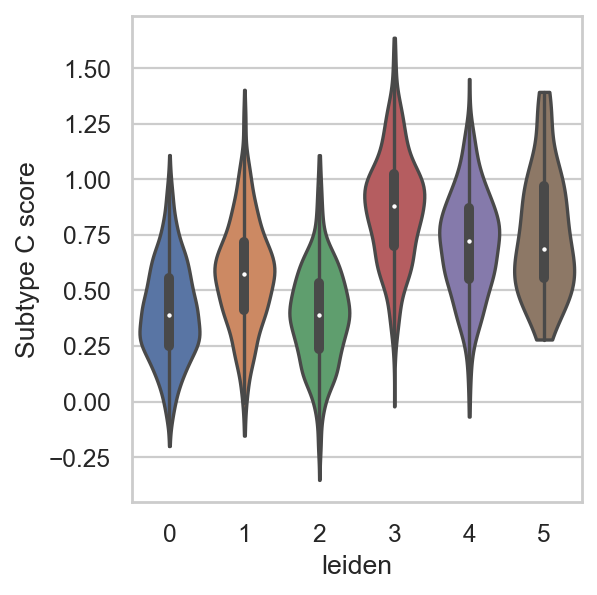

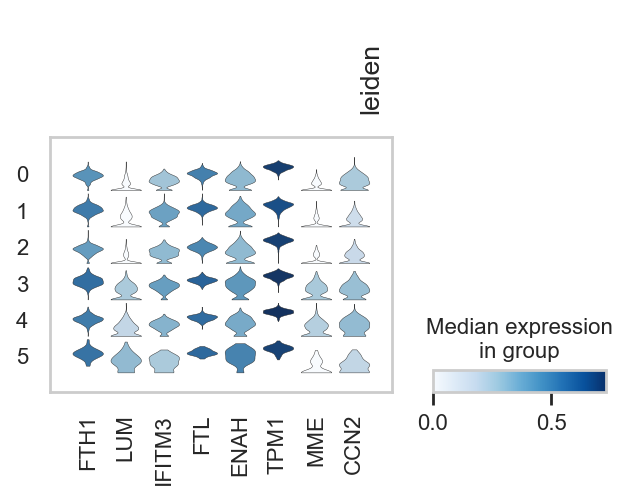

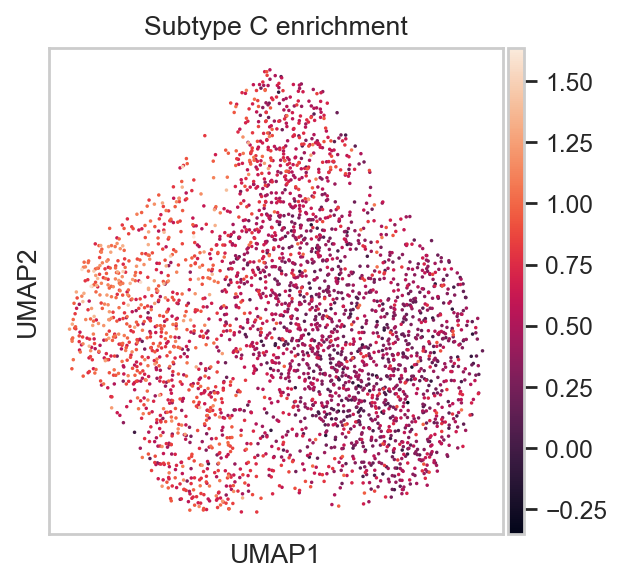

In [30]:
# reading in gene lists for gsea
subtype_C_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/gmt_files/Subtype_C_module.csv')]


adata.var_names_make_unique()


# keeping only genes that appear in the adata
subtype_C_genes = [x for x in subtype_C_genes if x in adata.var_names]


# Computing gsea
sc.tl.score_genes(adata, subtype_C_genes, ctrl_size=50, gene_pool=None, n_bins=25, 
                  score_name='Subtype_C_score', random_state=0, copy=False, use_raw=None)

sc.pl.violin(adata, ['Subtype_C_score'], groupby='leiden', stripplot=False, inner='box', 
             ylabel = 'Subtype C score')


sc.pl.stacked_violin(adata, subtype_C_genes, groupby='leiden',
                         var_group_positions=[(7, 8)], var_group_labels=['leiden'],
                    standard_scale="var",)

sc.pl.umap(
    adata,
    color=["Subtype_C_score"],
   # frameon=False,
    title = 'Subtype C enrichment',
    size = 10,
    legend_fontsize = 7
)

# Subtype labeling

In [ ]:
sc.pl.umap(adata, color=['leiden'], legend_fontsize=9, size = 20)

adata.obs['leiden'] = adata.obs['leiden'].astype('category')

adata.obs['leiden'][adata.obs['leiden']=='1']='3'
adata.obs['leiden'][adata.obs['leiden']=='0']='3'
adata.obs['leiden'][adata.obs['leiden']=='2']='3'
adata.obs['leiden'][adata.obs['leiden']=='5']='6'

# adding labels for trajectory subtype
# Fill in the clusters that belong to each cell type based on each marker in the plot above
cell_dict = { 'Subtype A': ['6'],  'Subtype B': ['3'], 'Subtype C':['4']}


# Initialize empty column in cell metadata
adata.obs['Subtype'] = np.nan


# Generate new assignments
for i in cell_dict.keys():
    ind = pd.Series(adata.obs.leiden).isin(cell_dict[i])
    adata.obs.loc[ind,'Subtype'] = i

    
# creating a dataframe with the cluster IDs
subtypes = pd.DataFrame(adata.obs['Subtype'].values)

# Define the number of clusters
n_subtypes = len(subtypes[0].unique())

# Define a color palette with a limited number of colors
colors = sns.color_palette('pastel', n_subtypes)

# Create a dictionary that maps each cluster ID to a color from the palette
#subtype_colors = dict(zip(sorted(subtypes[0].unique()), colors))

# Map the cluster IDs to their corresponding colors
#adata.uns['subtype_colors'] = [subtype_colors[c] for c in subtypes[0]]

sc.pl.umap(adata, color=['Subtype'], legend_fontsize=9, title = "OS152 Subtypes") #, palette = subtype_colors

# Cell cycle for scVI

In [ ]:
# save normalized counts in raw slot.
adata.raw = adata

# normalize to depth 10 000
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

# logaritmize
sc.pp.log1p(adata)

# scale
sc.pp.scale(adata)

sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

sc.pl.violin(adata, ['S_score', 'G2M_score'],
             jitter=0.4, groupby = 'leiden_scVI', rotation=45)

# Characterizing Clusters

In [ ]:
# performing dgea between two cell types
de_df = model.differential_expression(
    group1="3",
    group2="1",
    groupby="leiden_scVI"
)

de_df.head(20)

# comparing each cell type to the rest
de_df = model.differential_expression(
    groupby="leiden_scVI",
)

# identifying the top marklers within each cluster
markers = {}


cats = adata.obs.leiden_scVI.cat.categories


for i, c in enumerate(cats):
    cid = "{} vs Rest".format(c)
    cell_type_df = de_df.loc[de_df.comparison == cid]

    cell_type_df = cell_type_df[cell_type_df.lfc_median > 0.6]

    cell_type_df = cell_type_df[cell_type_df["bayes_factor"] > 2]
    cell_type_df = cell_type_df[cell_type_df["non_zeros_proportion1"] > 0.1]

    markers[c] = cell_type_df.index.tolist()[:30]
    
subtype_A_markers = {key: markers[key] for key in ['3'] if key in markers}

subtype_A_markers_384 = sum(subtype_A_markers.values(), [])

df = pd.read_csv("/Users/brendamelano/Desktop/subtype_A_markers.csv", delimiter=",")

OS742_subtype_A_markers = pd.concat([df[col].dropna() for col in df]).tolist()

OS742_subtype_A_markers = set(OS742_subtype_A_markers)
subtype_A_markers_384 = set(subtype_A_markers_384)

# Find the intersection (overlap) of the two sets
overlap_genes = OS742_subtype_A_markers.intersection(subtype_A_markers_384)

# Convert the intersection back to a list if you need to
overlap_genes_list = list(overlap_genes)

overlap_genes_list

# plotting dotplot
sc.pl.dotplot(
    adata,
    markers,
    groupby='leiden_scVI',
    dendrogram=True,
    color_map="Blues",
    swap_axes=True,
    use_raw=True,
    standard_scale="var",
)

# comparing each cell type to the rest
de_df = model.differential_expression(
    groupby="leiden_scVI",
)

# identifying the top marklers within each cluster
markers = {}

cats = adata.obs.leiden_scVI.cat.categories


for i, c in enumerate(cats):
    cid = "{} vs Rest".format(c)
    cell_type_df = de_df.loc[de_df.comparison == cid]

    cell_type_df = cell_type_df[cell_type_df.lfc_median > .9]

    cell_type_df = cell_type_df[cell_type_df["bayes_factor"] > 2] #originally 2
    cell_type_df = cell_type_df[cell_type_df["non_zeros_proportion1"] > 0.15] # originall.1

    markers[c] = cell_type_df.index.tolist()[:30]
    
    adata.var_names_make_unique()

# Old Subtype scores

In [6]:
adata.var_names_make_unique() 

angiogenic_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/gmt_files/angiogenic_markers.csv')]
angiogenic_genes_set = set(angiogenic_genes)
missing_genes = angiogenic_genes_set - set(adata.var_names)

print(f"Genes in the list not found in adata.var_names: {missing_genes}")


sc.tl.score_genes(adata, angiogenic_genes, ctrl_size=50, gene_pool=None, n_bins=25, score_name='angiogenic_score', random_state=0, copy=False, use_raw=None)

sc.pl.umap(
    adata,
    color=["angiogenic_score"],
    frameon=False,
)



# plotting the clusters
sc.pl.umap(
    adata,
    color=["leiden"],
    frameon=False,
)

sc.pl.violin(adata, ['angiogenic_score'], groupby='leiden', stripplot=False, inner='box')

sc.pl.violin(adata, 'COL1A1', groupby='leiden', stripplot=False, inner='box')

## Old subtype B
# reading in gene lists for gsea
ImmuneModulating_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/gmt_files/immune_modulating_genes.csv')]
adata.var_names_make_unique()

sc.tl.score_genes(adata, ImmuneModulating_genes, ctrl_size=50, gene_pool=None, n_bins=25, score_name='ImmuneModulating_score', random_state=0, copy=False, use_raw=None)

sc.pl.umap(
    adata,
    color=["ImmuneModulating_score"],
    frameon=False,
)

sc.pl.violin(adata, ['ImmuneModulating_score'], groupby='leiden', stripplot=False, inner='box')


sc.pl.stacked_violin(adata, ["UBE2C", "IGFBP7", "SPP1"], groupby = 'subtype')

# saving the adata file with the cluster ids
adata.write("/Users/brendamelano/Desktop/os_data/OS384/scvi_384_adata_subtypes.h5ad")

# Label subtypes

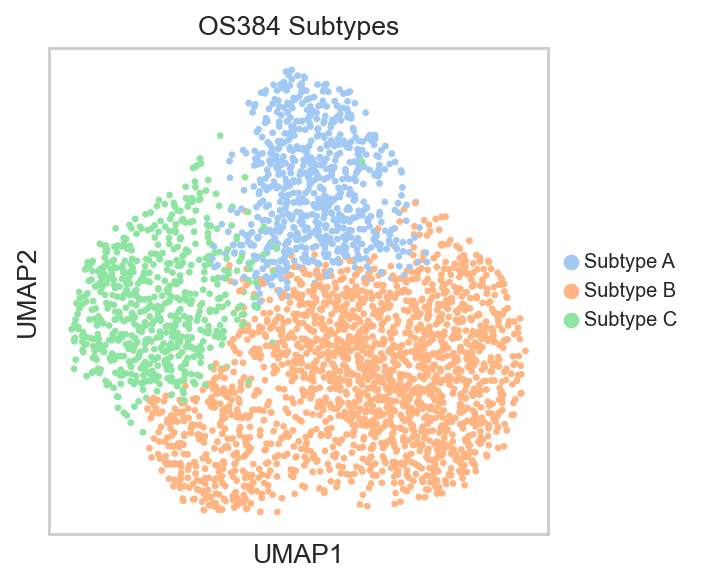

In [31]:
adata.obs['leiden'] = adata.obs['leiden'].astype('category')


adata.obs['leiden'][adata.obs['leiden']=='4']='0'
adata.obs['leiden'][adata.obs['leiden']=='2']='0'
adata.obs['leiden'][adata.obs['leiden']=='3']='5'



# adding labels for trajectory subtype
# Fill in the clusters that belong to each cell type based on each marker in the plot above
cell_dict = { 'Subtype A': ['1'],  'Subtype B': ['0'], 'Subtype C':['5']}


# Initialize empty column in cell metadata
adata.obs['Subtype'] = np.nan


# Generate new assignments
for i in cell_dict.keys():
    ind = pd.Series(adata.obs.leiden).isin(cell_dict[i])
    adata.obs.loc[ind,'Subtype'] = i

    
# creating a dataframe with the cluster IDs
subtypes = pd.DataFrame(adata.obs['Subtype'].values)


# Define the number of clusters
n_subtypes = len(subtypes[0].unique())


# Define a color palette with a limited number of colors
colors = sns.color_palette('pastel', n_subtypes)


# Create a dictionary that maps each cluster ID to a color from the palette
subtype_colors = dict(zip(sorted(subtypes[0].unique()), colors))


# Map the cluster IDs to their corresponding colors
adata.uns['subtype_colors'] = [subtype_colors[c] for c in subtypes[0]]


sc.pl.umap(adata, color=['Subtype'], legend_fontsize=9, title = "OS384 Subtypes", palette = subtype_colors)

# Subtype C Module Enrichment

computing score 'esc_genes'
    finished: added
    'esc_genes', score of gene set (adata.obs).
    98 total control genes are used. (0:00:00)


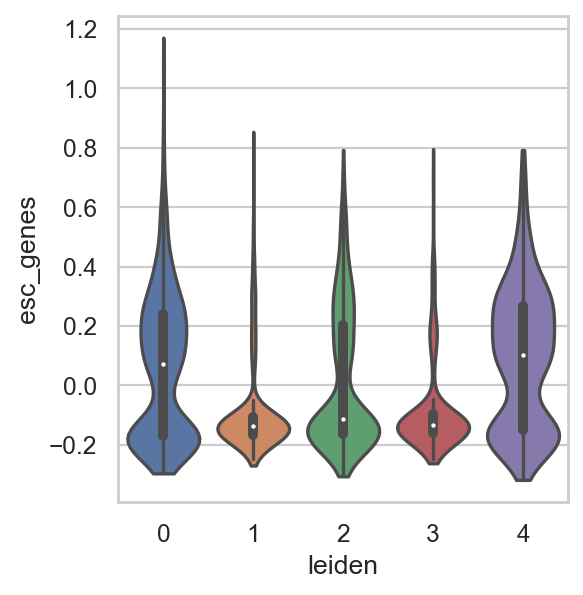

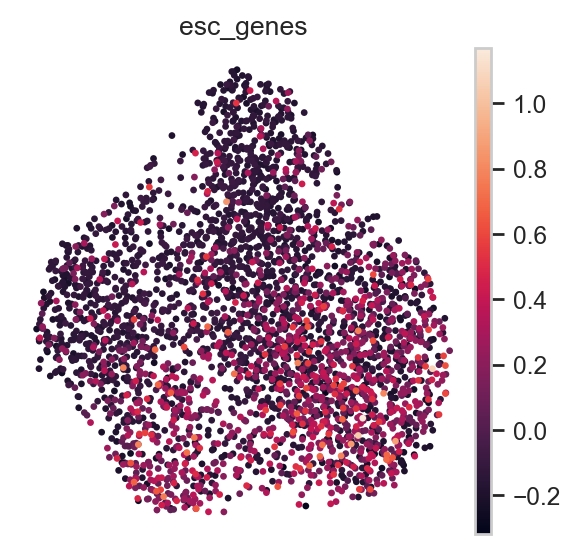

In [8]:
# reading in gene lists for gsea
esc_genes = [x.strip() for x in open('/Users/brendamelano/Desktop/gmt_files/esc_markers.csv')]


esc_genes

# computing gsea
sc.tl.score_genes(adata, esc_genes, ctrl_size=50, gene_pool=None, n_bins=25, score_name='esc_genes', random_state=0, copy=False, use_raw=None)
sc.pl.violin(adata, ['esc_genes'], groupby='leiden', stripplot=False, inner='box')

sc.pl.umap(
    adata,
    color=["esc_genes"],
    frameon=False,
)


# RNA velocity with scVelo

computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on distances
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 1/12 cores)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/404 [00:00<?, ?gene/s]

    finished (0:02:03) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:01) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/12 cores)


/Users/brendamelano/opt/anaconda3/lib/python3.9/site-packages/ipywidgets/widgets/widget.py:528: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/3244 [00:00<?, ?cells/s]

    finished (0:00:03) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


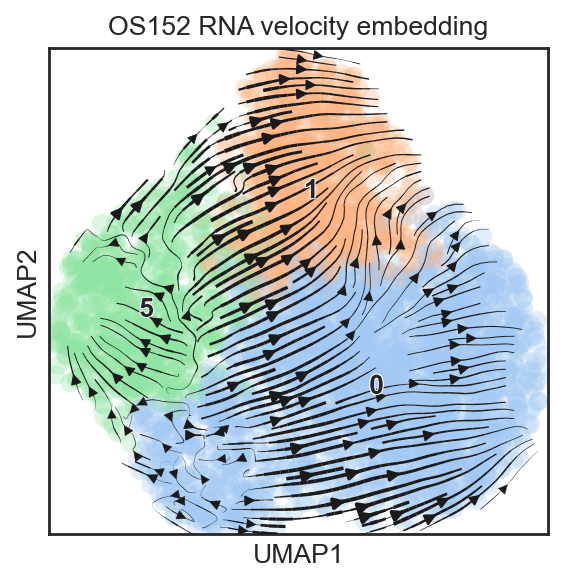

In [32]:
# computing the moments
scv.pp.moments(adata, mode = 'distances')
 

# recovering dynamics
scv.tl.recover_dynamics(adata)

# inferring the DYNAMIC velocities
scv.tl.velocity(adata, mode='dynamical')


# computing the velocity graph
scv.tl.velocity_graph(adata)

# creating a dataframe with the cluster IDs
clusters = pd.DataFrame(adata.obs['leiden'].astype('int64').values)

# Define the number of clusters
n_clusters = len(clusters[0].unique())

# Define a color palette with a limited number of colors
colors = sns.color_palette('pastel', n_clusters)

# Create a dictionary that maps each cluster ID to a color from the palette
cluster_colors = dict(zip(sorted(clusters[0].unique()), colors))

# Map the cluster IDs to their corresponding colors
adata.uns['ClusterName_colors'] = [cluster_colors[c] for c in clusters[0]]

# Set the plot style to 'white' to remove grid lines
sns.set_style('white')

# Plot the stream with the discrete color legend
scv.pl.velocity_embedding_stream(adata, basis='umap', color='leiden', 
                                 palette=colors, title = 'OS152 RNA velocity embedding',
                                frameon = True)

# saving the adata file with the cluster ids
#adata.write("/Users/brendamelano/Desktop/OS384_adata_labeled.h5ad")

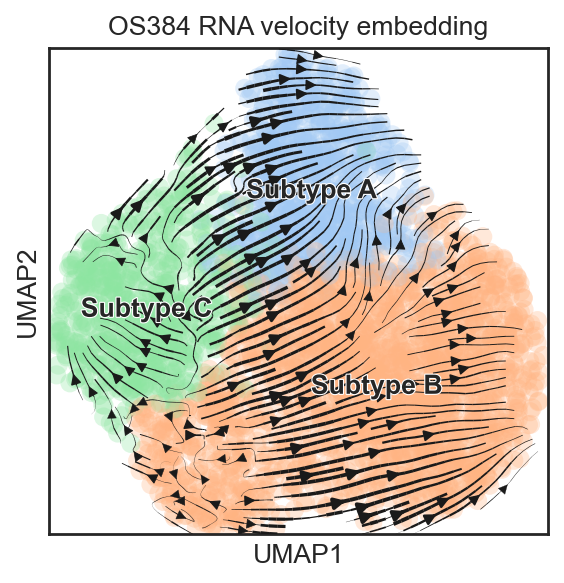

In [34]:
# Plot the stream with the discrete color legend
scv.pl.velocity_embedding_stream(adata, basis='umap', color='Subtype', 
                                 palette=colors, title = 'OS384 RNA velocity embedding',
                                frameon = True)

# GSEA

In [4]:
# Defining the directory for the gmt files
directory = '/Users/brendamelano/Desktop/gmt_files'

# Create a dictionary to store gene lists
gene_lists = {}

# Create variables for gene lists
for filename in os.listdir(directory):
    if filename.endswith('.txt'):
        variable_name = os.path.splitext(filename)[0].upper()
        variable_name += "_genes"
        with open(os.path.join(directory, filename)) as f:
            gene_lists[variable_name] = [line.strip() for line in f]

# Create a dictionary to store gene scores for each module
gene_scores = {}

# Quantify enrichment for each gene list
for gene_list_name, gene_list in gene_lists.items():
    scores_key = gene_list_name + "_score"
    try:
        gene_scores[gene_list_name] = sc.tl.score_genes(
            adata, gene_list, ctrl_size=50, gene_pool=None,
            n_bins=5, score_name=scores_key, random_state=0, 
            copy=False, use_raw=None
        )
    except KeyError:
        continue


computing score 'IL2_genes_score'
    finished: added
    'IL2_genes_score', score of gene set (adata.obs).
    197 total control genes are used. (0:00:00)
computing score 'MTOR_genes_score'
    finished: added
    'MTOR_genes_score', score of gene set (adata.obs).
    195 total control genes are used. (0:00:00)
computing score 'FOCAL_ADHESION_PI3KAKTMTOR_genes_score'
    finished: added
    'FOCAL_ADHESION_PI3KAKTMTOR_genes_score', score of gene set (adata.obs).
    190 total control genes are used. (0:00:00)
computing score 'PDGF_ERK1_DOWN_genes_score'
    finished: added
    'PDGF_ERK1_DOWN_genes_score', score of gene set (adata.obs).
    196 total control genes are used. (0:00:00)
computing score 'TNFA_genes_score'


    finished: added
    'TNFA_genes_score', score of gene set (adata.obs).
    148 total control genes are used. (0:00:00)
computing score 'GCNP_genes_score'
    finished: added
    'GCNP_genes_score', score of gene set (adata.obs).
    196 total control genes are used. (0:00:00)
computing score 'CSR_genes_score'
    finished: added
    'CSR_genes_score', score of gene set (adata.obs).
    196 total control genes are used. (0:00:00)
computing score 'ESC_genes_score'
    finished: added
    'ESC_genes_score', score of gene set (adata.obs).
    199 total control genes are used. (0:00:00)
computing score 'PI3KAKTMTOR_genes_score'
    finished: added
    'PI3KAKTMTOR_genes_score', score of gene set (adata.obs).
    150 total control genes are used. (0:00:00)
computing score 'STK33_genes_score'
    finished: added
    'STK33_genes_score', score of gene set (adata.obs).
    197 total control genes are used. (0:00:00)
computing score 'VEGFA_genes_score'


    finished: added
    'VEGFA_genes_score', score of gene set (adata.obs).
    189 total control genes are used. (0:00:00)
computing score 'KRAS_genes_score'
    finished: added
    'KRAS_genes_score', score of gene set (adata.obs).
    196 total control genes are used. (0:00:00)
computing score 'TGFB_genes_score'
    finished: added
    'TGFB_genes_score', score of gene set (adata.obs).
    149 total control genes are used. (0:00:00)
computing score 'EMT_genes_score'
    finished: added
    'EMT_genes_score', score of gene set (adata.obs).
    199 total control genes are used. (0:00:00)
computing score 'EZH2_genes_score'
    finished: added
    'EZH2_genes_score', score of gene set (adata.obs).
    193 total control genes are used. (0:00:00)
computing score 'LEF1_genes_score'
    finished: added
    'LEF1_genes_score', score of gene set (adata.obs).
    195 total control genes are used. (0:00:00)


In [13]:
adata.var_names_make_unique()


# computing gsea
sc.tl.score_genes(adata, VEGFA_genes, ctrl_size=50, gene_pool=None, n_bins=5, score_name='VEGFA_score', random_state=0, copy=False, use_raw=None)
sc.pl.violin(adata, ['VEGFA_score'], groupby='leiden', stripplot=False, inner='box')

# GSEA for PI3K/AKT
# computing gsea
sc.tl.score_genes(adata, PI3KAKTMTOR, ctrl_size=50, gene_pool=None, n_bins=25, score_name='PI3KAKTMTOR', random_state=0, copy=False, use_raw=None)
sc.pl.violin(adata, ['PI3KAKTMTOR'], groupby='leiden', stripplot=False, inner='box')


sc.pl.stacked_violin(adata, PI3KAKTMTOR, groupby='leiden',
                         var_group_positions=[(7, 8)], var_group_labels=['cluster'],
                    standard_scale="var",)



NameError: name 'VEGFA_genes' is not defined

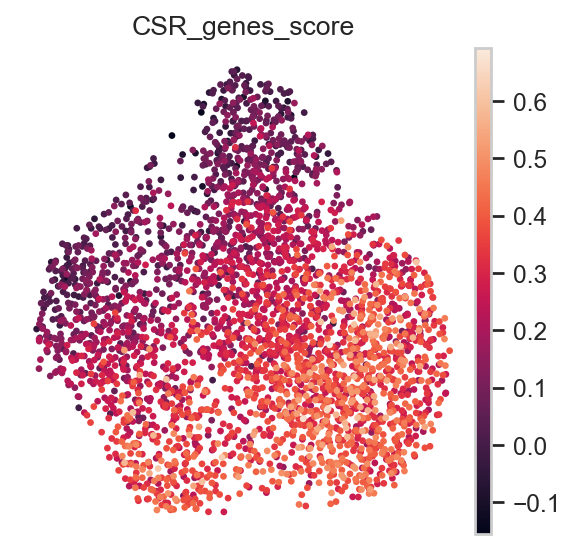

In [9]:


sc.pl.umap(
    adata,
    color=["CSR_genes_score"],
    frameon=False,
)

In [25]:
scores = ['CSR_genes_score','MTOR_genes_score', 'GCNP_genes_score','LEF1_genes_score',
          'FOCAL_ADHESION_PI3KAKTMTOR_genes_score', 'TGFB_genes_score',   'STK33_genes_score',
          'PDGF_ERK1_DOWN_genes_score','IL2_genes_score',
         'ESC_genes_score',  'TNFA_genes_score', 'KRAS_genes_score']


sc.pl.matrixplot(
    adata,
    scores,
    "leiden",
    dendrogram=False,
    cmap="Blues",
    standard_scale="var",
    colorbar_title="column scaled\nexpression",
)

# Cell type labeling for scVI

In [10]:
# converting the cluster to category type
adata.obs['leiden_scVI'] = adata.obs['leiden_scVI'].astype('category')

adata.obs['leiden_scVI'][adata.obs['leiden_scVI']=='2']='3'


# adding labels for trajectory subtype
# Fill in the clusters that belong to each cell type based on each marker in the plot above
cell_dict = { 'esc': ['1'], 'immuneModulating': ['0'], 'angiogenic': ['3']}


# Initialize empty column in cell metadata
adata.obs['subtype'] = np.nan


# Generate new assignments
for i in cell_dict.keys():
    ind = pd.Series(adata.obs.leiden_scVI).isin(cell_dict[i])
    adata.obs.loc[ind,'subtype'] = i
    
sc.pl.umap(adata, color=['subtype'], legend_fontsize=9)
